In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
df = pd.read_csv("seismic-bumps.csv")

In [45]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


## Feature preprocessing (light)

In [46]:
#remove useless variables from the dataset
column2drop = ['seismoacoustic', 'gdenergy', 'gdpuls', 'hazard', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy']
df.drop(column2drop, axis=1, inplace=True)

In [47]:
df.head()

,seismic,shift,genergy,gpuls,nbumps,nbumps2,maxenergy,class
0,a,N,15180,48,0,0,0,0
1,a,N,14720,33,1,0,2000,0
2,a,N,8050,30,0,0,0,0
3,a,N,28820,171,1,0,3000,0
4,a,N,12640,57,0,0,0,0


In [48]:
###### Lecture Pipeline ######
# you can/have to modify the order for your project,
# e.g. hyperparameter tuning before evaluating a decision tree

# Hold-out
from sklearn.model_selection import train_test_split

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Optional: KNN
from sklearn.neighbors import KNeighborsClassifier

######## Evaluation #######
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Optional: baseline comparison
from sklearn.dummy import DummyClassifier
###########################

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# cross-validation
from sklearn.model_selection import cross_val_score

In [49]:
# Printing categorical first 5 values before pre-processing

print("sesmic's first 5 values: ", df['seismic'].values[:5])
print("shift's first 5 values: ", df['shift'].values[:5])

sesmic's first 5 values:  ['a' 'a' 'a' 'a' 'a']
shift's first 5 values:  ['N' 'N' 'N' 'N' 'N']


In [50]:
# Transform categorical attributes ('seismic' and 'shift') into numerical ones 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['seismic'] = le.fit_transform(df['seismic'])
df['shift'] = le.fit_transform(df['shift'])

In [51]:
# Printing categorical first 5 values after pre-processing

print("sesmic's first 5 values: ", df['seismic'].values[:5])
print("shift's first 5 values: ", df['shift'].values[:5])

sesmic's first 5 values:  [0 0 0 0 0]
shift's first 5 values:  [0 0 0 0 0]


## APPLYING CLASSIFICATION

In [52]:
# Spliting dataset into training-set and test-set using HOLD-OUT method

attributes = [col for col in df.columns if col != 'class']
X = df[attributes].values
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [53]:
# Printing the shape of dataset, training-set and test-set ([number_of_rows], [number_of_columns])

df.shape, X_train.shape, X_test.shape

((2584, 8), (1808, 7), (776, 7))

In [54]:
# Applying the classification algorithm with some parameters

clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=None ,
                             min_samples_split=10,
                             min_samples_leaf=5,
                            )

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5,
                       min_samples_split=10)

In [55]:
# Priting the attibutes in order of importance according to the classification algorithm applied

imp_dict = {attr: clf.feature_importances_[i] for i, attr in enumerate(attributes)}
imp_dict

{k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}

{'gpuls': 0.3880441308065331,
 'genergy': 0.2602857252716013,
 'nbumps': 0.21670081711449002,
 'maxenergy': 0.08350578603856917,
 'seismic': 0.02991339285495021,
 'nbumps2': 0.021550147913856083,
 'shift': 0.0}

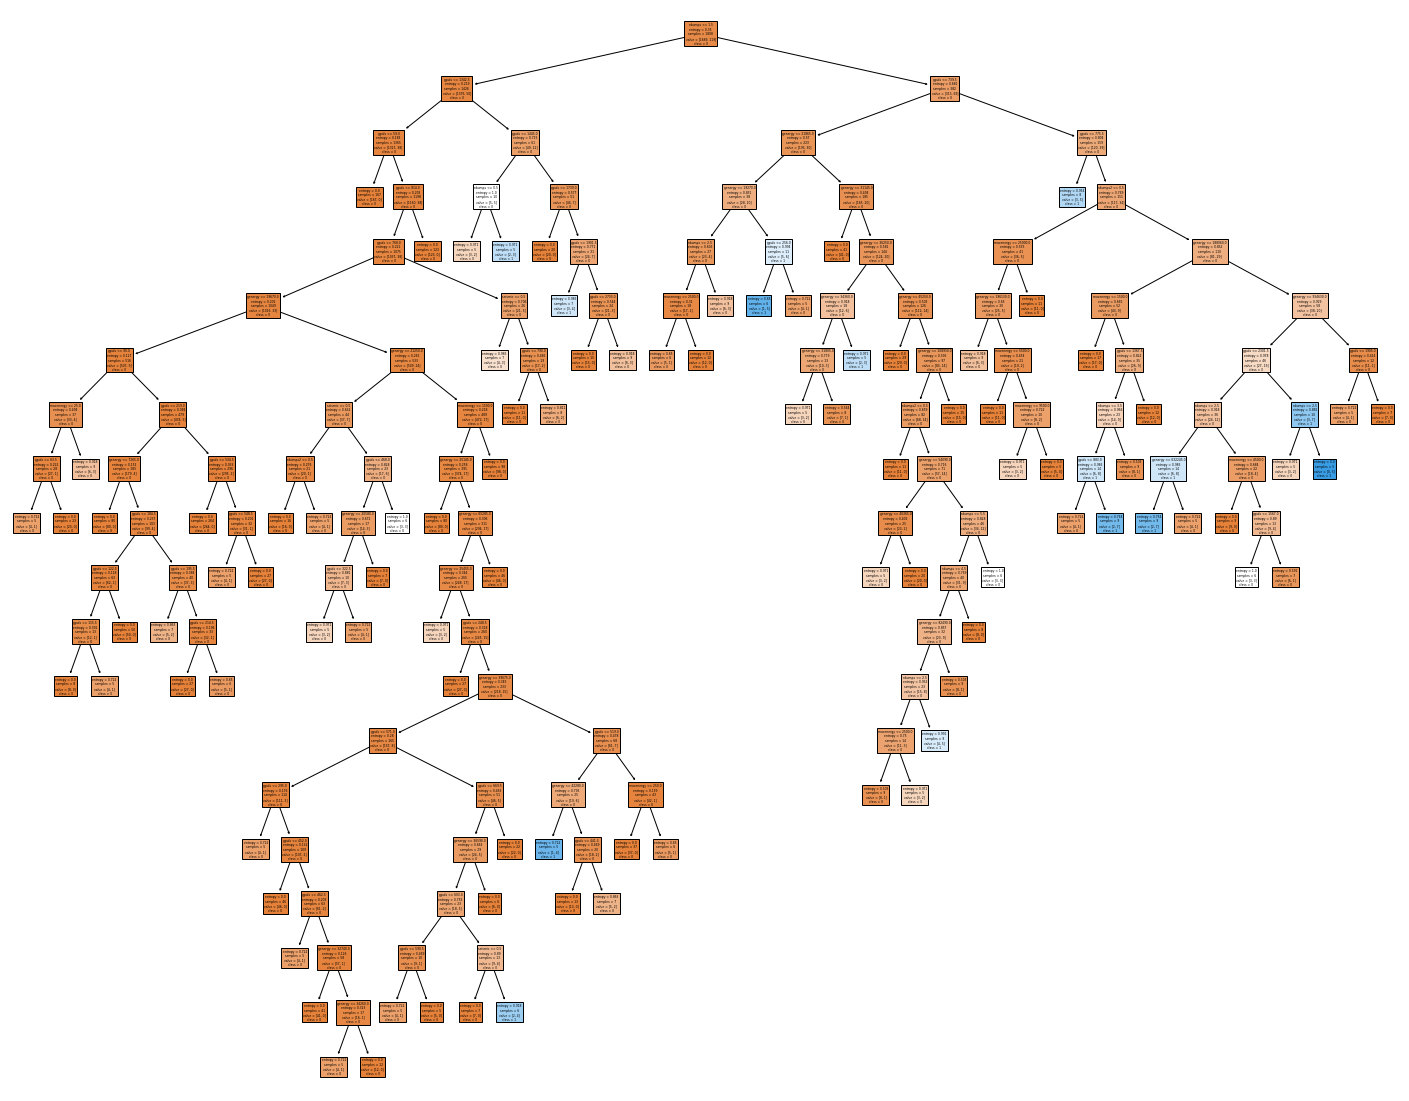

In [56]:
# Plotting the entire Decision Tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=[str(v) for v in clf.classes_],
                   filled=True)

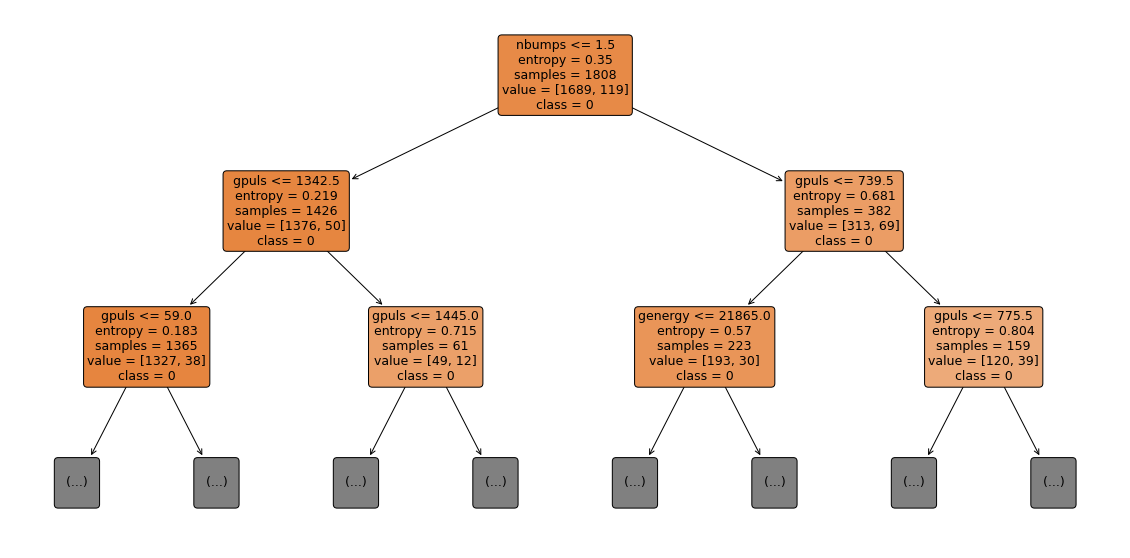

In [57]:
# Plotting only the first 3 levels of the DT

fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=[str(v) for v in clf.classes_],
                   filled=True, 
                   rounded=True,
                   max_depth=2)

# 

In [ ]:
# Applying the model to the training-set

y_pred = clf.predict(X_train)

In [27]:
# Printing the 'Accuracy' and 'F1' values for evaluate the quality of the prediction on the training-set

print('Accuracy', accuracy_score(y_train, y_pred))
print('F1', f1_score(y_train, y_pred, average=None))

Accuracy 0.9507743362831859
F1 [0.97399942 0.5388601 ]


In [28]:
# Printing other evaluation indences

print( classification_report(y_train, y_pred) )

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1689
           1       0.70      0.44      0.54       119

    accuracy                           0.95      1808
   macro avg       0.83      0.71      0.76      1808
weighted avg       0.94      0.95      0.95      1808



In [29]:
# Printing of confusion_matrix as seen in the lecture

cf = confusion_matrix(y_train, y_pred, labels=[1,0])
cf

array([[  52,   67],
       [  22, 1667]])

In [30]:
# Applying the model to the test-set (default threshold = 0.5)

y_pred = clf.predict( X_test )

y_pred[:5]

In [31]:
# Here the output is not a single value, but pair of value 
# [probability to belong to class '0', prob. to belong to class to belong to class '1']

y_score = clf.predict_proba(X_test)
y_score[:6]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [32]:
# Printing of AUC value (aka Area under the ROC)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6217849898580122


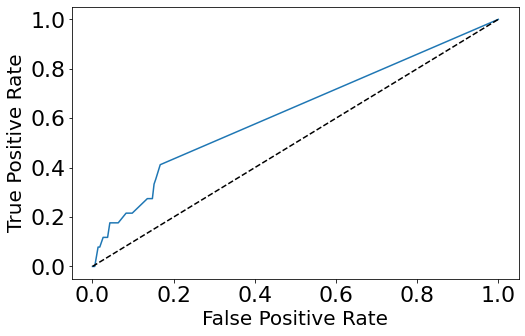

In [33]:
# Plotting of ROC Curve

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()